In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import random
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import numpy as np
import os

In [2]:
ruta_train = os.path.join("..","..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

In [3]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

### BASELINE PARA P1

Gana el que haya dado más golpes

In [4]:
y_pred = X_test["SIG_STR_DIFF"] < 0
accuracy_score(y_test,y_pred)

0.7085798816568047

In [5]:
# Crear el modelo con los mejores hiperparámetros encontrados
mejor_arbol = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=13,
    random_state=42
)

# Entrenar el modelo
mejor_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=13,
                       random_state=42)

In [6]:
from xgboost import XGBClassifier

# Crear el modelo con los mejores hiperparámetros encontrados
mejor_xgboost = XGBClassifier(
    alpha=0,
    colsample_bytree=0.7,
    gamma=0,
    reg_lambda=1.0,
    learning_rate=0.3,
    max_depth=3,
    min_child_weight=2,
    n_estimators=200,
    scale_pos_weight=1,
    subsample=0.8,
    random_state=42
)

# Entrenar el modelo
mejor_xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
ruta_train_x = os.path.join("..","..","..", "data", "P1","train_x.parquet")
x_train2 = pd.read_parquet(ruta_train_x) 
ruta_test_x = os.path.join("..","..","..", "data", "P1","test_x.parquet")
x_test2 = pd.read_parquet(ruta_test_x) 

ruta_train_y = os.path.join("..","..","..", "data", "P1","train_y.parquet")
y_train2 = pd.read_parquet(ruta_train_y) 
ruta_test_y = os.path.join("..","..","..", "data", "P1","test_y.parquet")
y_test2 = pd.read_parquet(ruta_test_y) 

# Crear el modelo con los mejores hiperparámetros encontrados
mejor_logistic = LogisticRegression(
    C=7039.020013771433,
    class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
    l1_ratio=0.16982166211009408,
    penalty='l1',
    solver='saga',
    random_state=42
)

# Entrenar el modelo
mejor_logistic.fit(x_train2, y_train2)

c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=7039.020013771433,
                   class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
                   l1_ratio=0.16982166211009408, penalty='l1', random_state=42,
                   solver='saga')


Resultados para Árbol de Decisión
              precision    recall  f1-score   support

       False       0.86      0.85      0.85      1179
        True       0.79      0.81      0.80       849

    accuracy                           0.83      2028
   macro avg       0.83      0.83      0.83      2028
weighted avg       0.83      0.83      0.83      2028



<Figure size 1000x800 with 0 Axes>

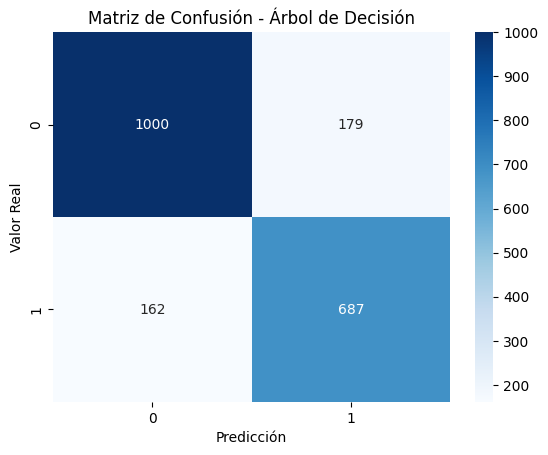

AUC de Árbol de Decisión: 0.86


Resultados para XGBoost
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      1179
        True       0.95      0.94      0.94       849

    accuracy                           0.95      2028
   macro avg       0.95      0.95      0.95      2028
weighted avg       0.95      0.95      0.95      2028



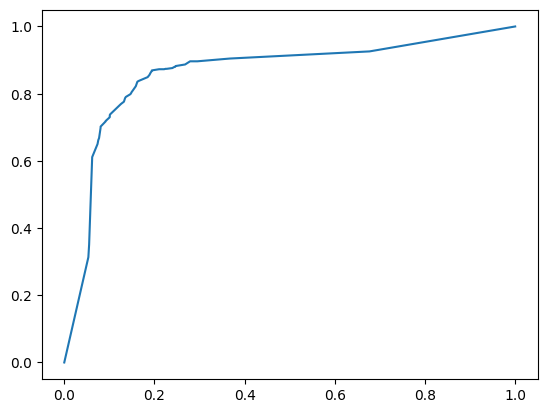

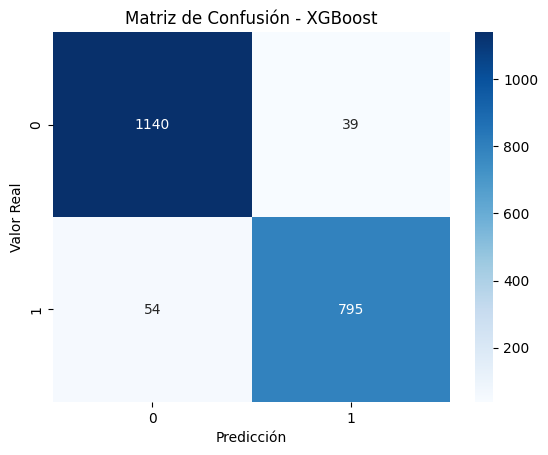

AUC de XGBoost: 0.99


Resultados para Regresión Logística
              precision    recall  f1-score   support

       False       0.94      0.92      0.93      1179
        True       0.89      0.92      0.90       849

    accuracy                           0.92      2028
   macro avg       0.91      0.92      0.91      2028
weighted avg       0.92      0.92      0.92      2028



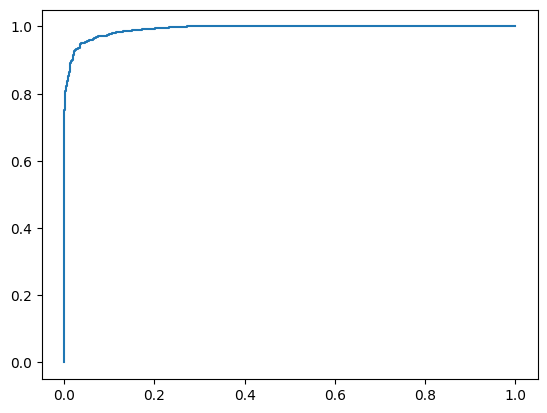

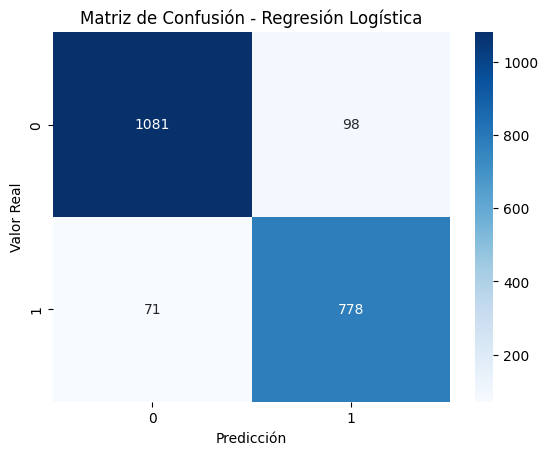

AUC de Regresión Logística: 0.98



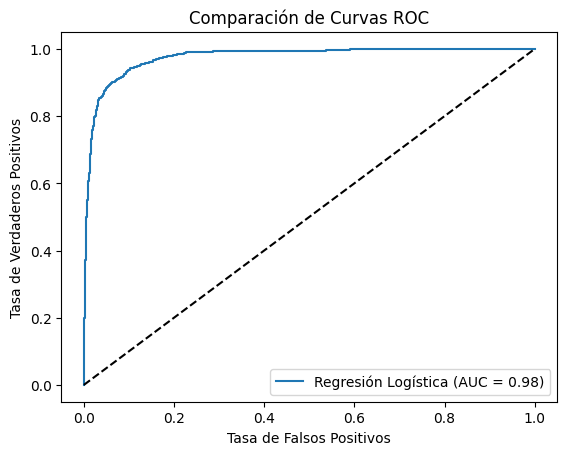

In [8]:
# Evaluar modelos y graficar curvas ROC
plt.figure(figsize=(10, 8))
resultados = {}

# Diccionario de modelos (ya definidos en el notebook)
modelos = {
    'Árbol de Decisión': mejor_arbol,
    'XGBoost': mejor_xgboost,
    'Regresión Logística': mejor_logistic
}

for nombre, modelo in modelos.items():
    # Usar el conjunto de test correspondiente:
    # Para Regresión Logística se usan x_test2 e y_test2, para los otros se usan X_test e y_test
    if nombre == 'Regresión Logística':
        X_eval, y_eval = x_test2, y_test2
    else:
        X_eval, y_eval = X_test, y_test
    
    # Evaluación del modelo
    y_pred = modelo.predict(X_eval)
    y_prob = modelo.predict_proba(X_eval)[:, 1]
    
    print(f"\nResultados para {nombre}")
    print("=" * 50)
    print(classification_report(y_eval, y_pred))
    
    # Matriz de confusión
    plt.figure()
    cm = confusion_matrix(y_eval, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_eval, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC de {nombre}: {roc_auc:.2f}\n")
    resultados[nombre] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}
    
    # Graficar la curva ROC de cada modelo en la misma figura para comparación
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.2f})")

# Configuración de la gráfica ROC comparativa
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Comparación de Curvas ROC")
plt.legend(loc="lower right")
plt.show()

Árbol de Decisión AUC: 0.86
XGBoost AUC: 0.99
Regresión Logística AUC: 0.98


C:\Users\araca\AppData\Local\Temp\ipykernel_19684\919712153.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_values, palette=colors)


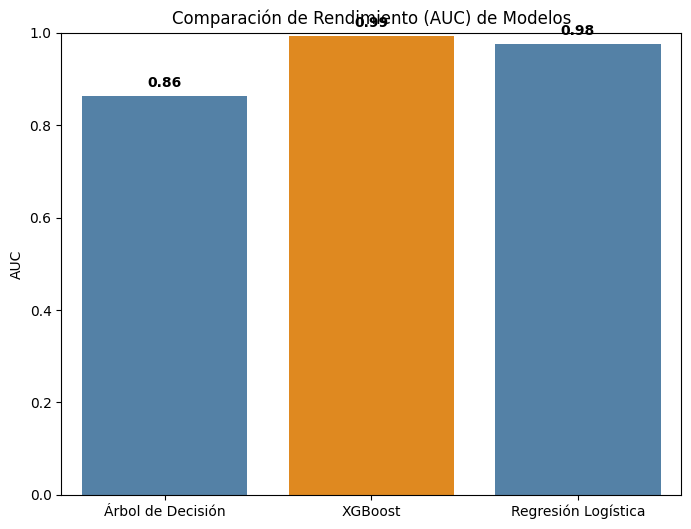

In [9]:
# Diccionario para almacenar los AUC de cada modelo
auc_results = {}

# Evaluar cada modelo usando el conjunto de test correspondiente:
for nombre, modelo in modelos.items():
    if nombre == 'Regresión Logística':
        X_eval, y_eval = x_test2, y_test2
    else:
        X_eval, y_eval = X_test, y_test

    # Calcular probabilidades y AUC
    y_prob = modelo.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_eval, y_prob)
    model_auc = auc(fpr, tpr)
    auc_results[nombre] = model_auc
    print(f"{nombre} AUC: {model_auc:.2f}")

# Determinar el modelo con mayor AUC
best_model = max(auc_results, key=auc_results.get)

# Preparar datos para el gráfico
model_names = list(auc_results.keys())
auc_values = list(auc_results.values())

# Asignar color distinto al mejor modelo
colors = ['steelblue' if model != best_model else 'darkorange' for model in model_names]

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=auc_values, palette=colors)
plt.title("Comparación de Rendimiento (AUC) de Modelos")
plt.ylabel("AUC")
plt.ylim(0, 1)
for i, value in enumerate(auc_values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontweight='bold')
plt.show()

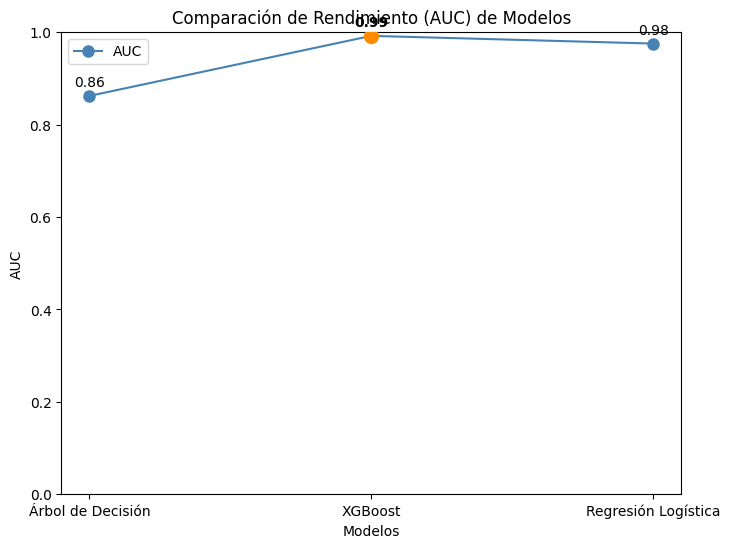

In [10]:
# Preparar listas con nombre de modelos y sus respectivos AUC
model_names = list(auc_results.keys())
auc_values = list(auc_results.values())

# Determinar el modelo con mayor AUC
best_model = max(auc_results, key=auc_results.get)
best_idx = model_names.index(best_model)

plt.figure(figsize=(8, 6))
plt.plot(model_names, auc_values, marker='o', linestyle='-', color='steelblue', markersize=8, label='AUC')
plt.xlabel("Modelos")
plt.ylabel("AUC")
plt.title("Comparación de Rendimiento (AUC) de Modelos")

# Resaltar el mejor modelo
plt.scatter(model_names[best_idx], auc_values[best_idx], color='darkorange', s=100, zorder=5)
plt.text(model_names[best_idx], auc_values[best_idx] + 0.02, f"{auc_values[best_idx]:.2f}", 
         ha='center', fontweight='bold')

# Agregar etiquetas para el resto de modelos
for i, value in enumerate(auc_values):
    if i != best_idx:
        plt.text(model_names[i], value + 0.02, f"{value:.2f}", ha='center')

plt.ylim(0, 1)
plt.legend()
plt.show()


Evaluando métricas complementarias para: Árbol de Decisión
--- Árbol de Decisión ---
Accuracy: 0.8318540433925049
Precision: 0.7933025404157044
Recall: 0.8091872791519434
F1 Score: 0.8011661807580175
Log Loss: 2.4938225566022703

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.86      0.85      0.85      1179
        True       0.79      0.81      0.80       849

    accuracy                           0.83      2028
   macro avg       0.83      0.83      0.83      2028
weighted avg       0.83      0.83      0.83      2028



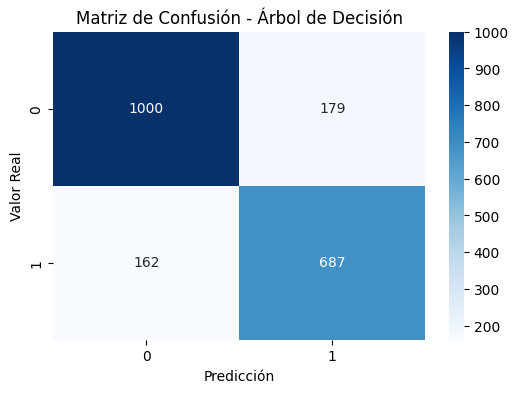

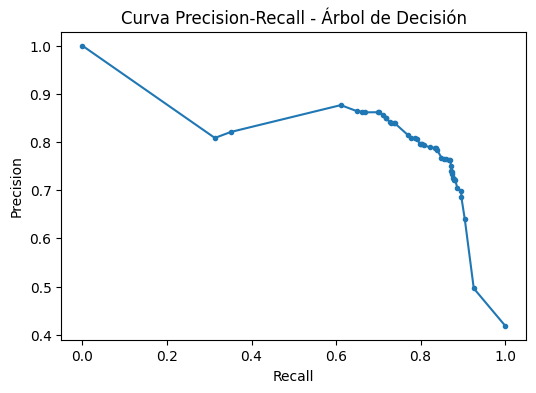


Evaluando métricas complementarias para: XGBoost
--- XGBoost ---
Accuracy: 0.9541420118343196
Precision: 0.9532374100719424
Recall: 0.9363957597173145
F1 Score: 0.9447415329768271
Log Loss: 0.11250365563690091

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      1179
        True       0.95      0.94      0.94       849

    accuracy                           0.95      2028
   macro avg       0.95      0.95      0.95      2028
weighted avg       0.95      0.95      0.95      2028



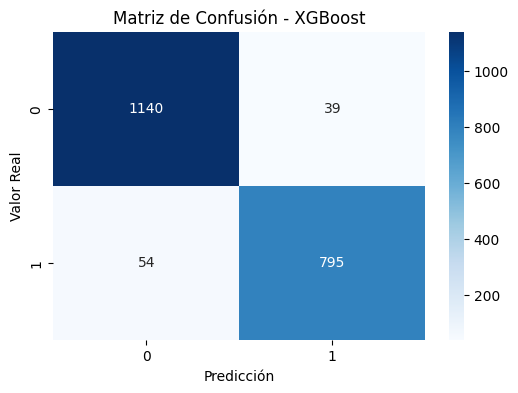

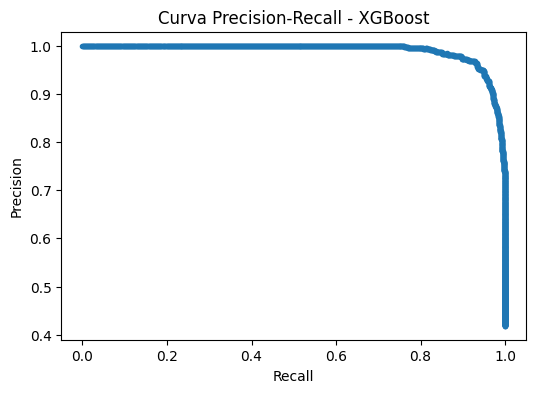


Evaluando métricas complementarias para: Regresión Logística
--- Regresión Logística ---
Accuracy: 0.9166666666666666
Precision: 0.8881278538812786
Recall: 0.9163722025912838
F1 Score: 0.9020289855072464
Log Loss: 0.2016448737982344

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.94      0.92      0.93      1179
        True       0.89      0.92      0.90       849

    accuracy                           0.92      2028
   macro avg       0.91      0.92      0.91      2028
weighted avg       0.92      0.92      0.92      2028



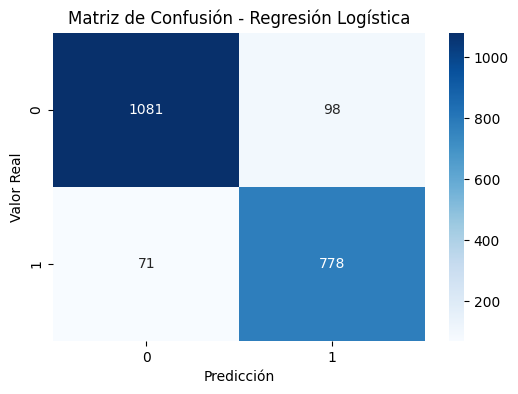

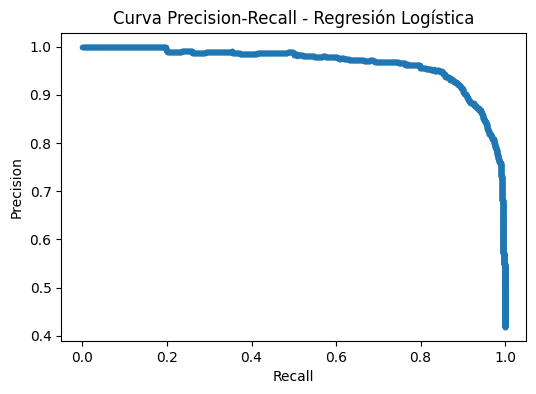


Evaluación por segmentos para Árbol de Decisión usando la variable 'REV_DIFF'
Segmento (-4.001, 0.0]: Accuracy=0.84, F1=0.81, Precision=0.81, Recall=0.81
Segmento (0.0, 3.0]: Accuracy=0.75, F1=0.68, Precision=0.59, Recall=0.80


C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segmento, data in X_seg.groupby("segmento"):
C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Segmento ({variable})", y="accuracy", data=metrics_df, ax=ax[0,0], palette="viridis")
C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Segmento ({variable})"

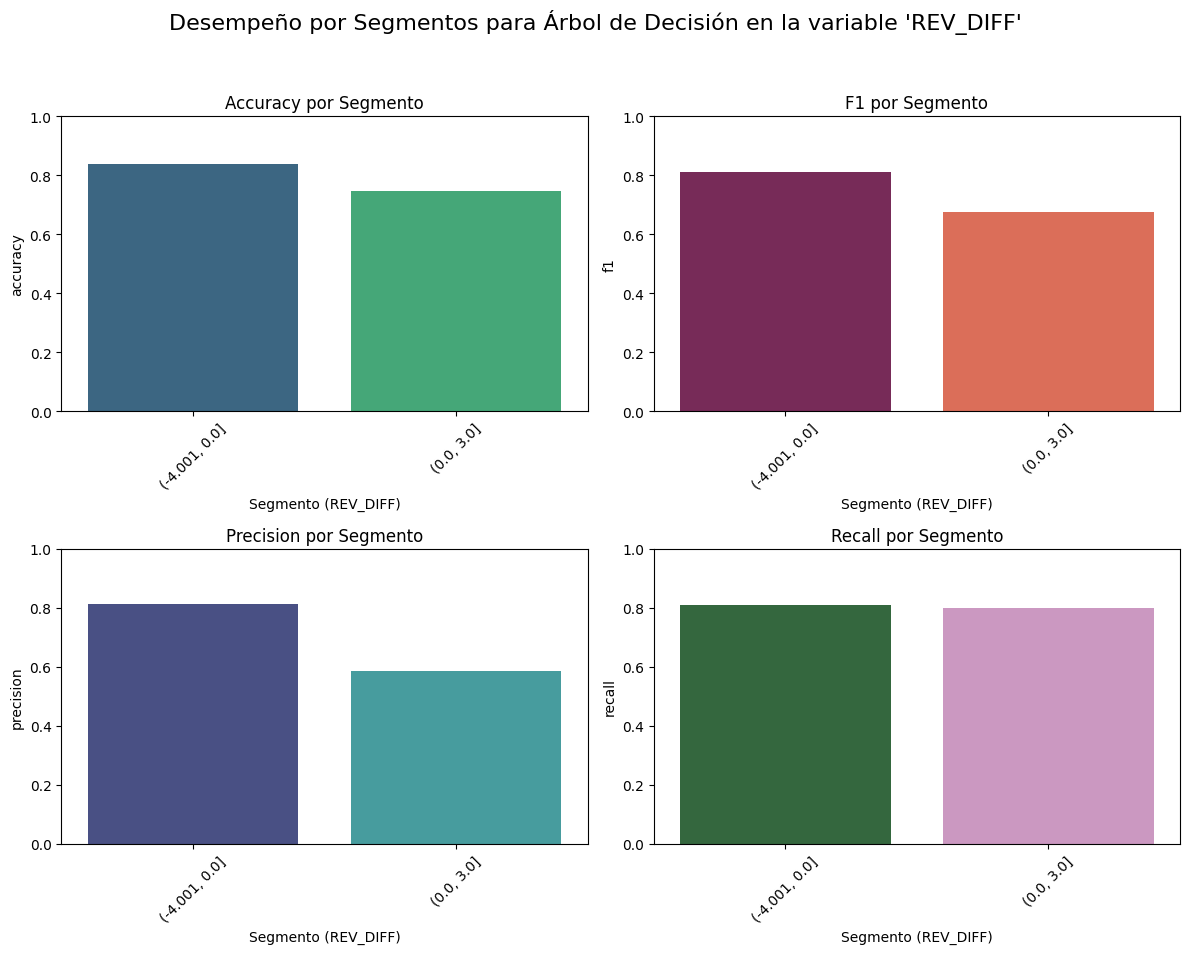


Evaluación por segmentos para XGBoost usando la variable 'REV_DIFF'
Segmento (-4.001, 0.0]: Accuracy=0.96, F1=0.95, Precision=0.96, Recall=0.94
Segmento (0.0, 3.0]: Accuracy=0.92, F1=0.88, Precision=0.86, Recall=0.91


C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segmento, data in X_seg.groupby("segmento"):
C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Segmento ({variable})", y="accuracy", data=metrics_df, ax=ax[0,0], palette="viridis")
C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Segmento ({variable})"

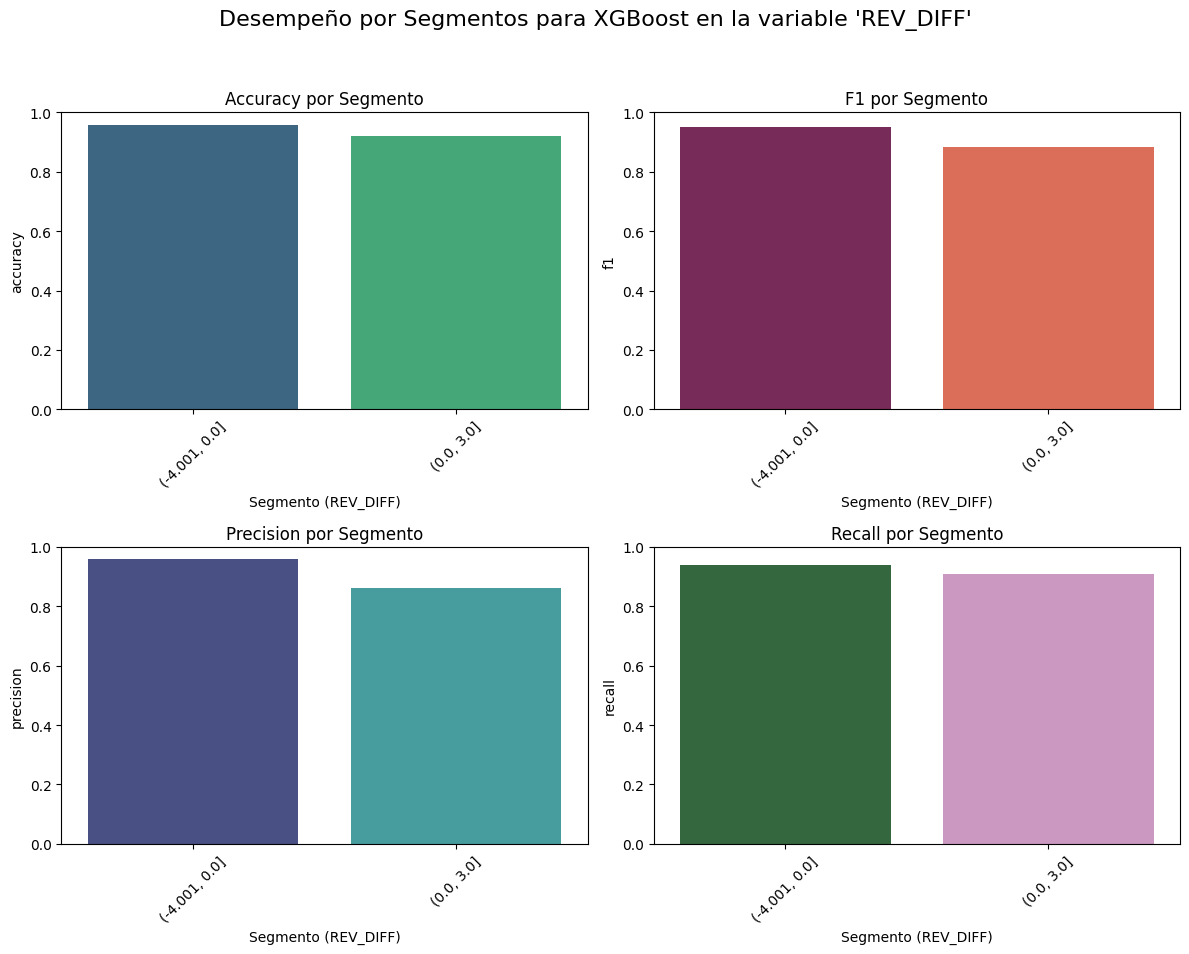


Evaluación por segmentos para Regresión Logística usando la variable 'REV_DIFF'
Segmento (-4.001, 0.0]: Accuracy=0.92, F1=0.90, Precision=0.89, Recall=0.92
Segmento (0.0, 3.0]: Accuracy=0.91, F1=0.86, Precision=0.86, Recall=0.87


C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segmento, data in X_seg.groupby("segmento"):
C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Segmento ({variable})", y="accuracy", data=metrics_df, ax=ax[0,0], palette="viridis")
C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Segmento ({variable})"

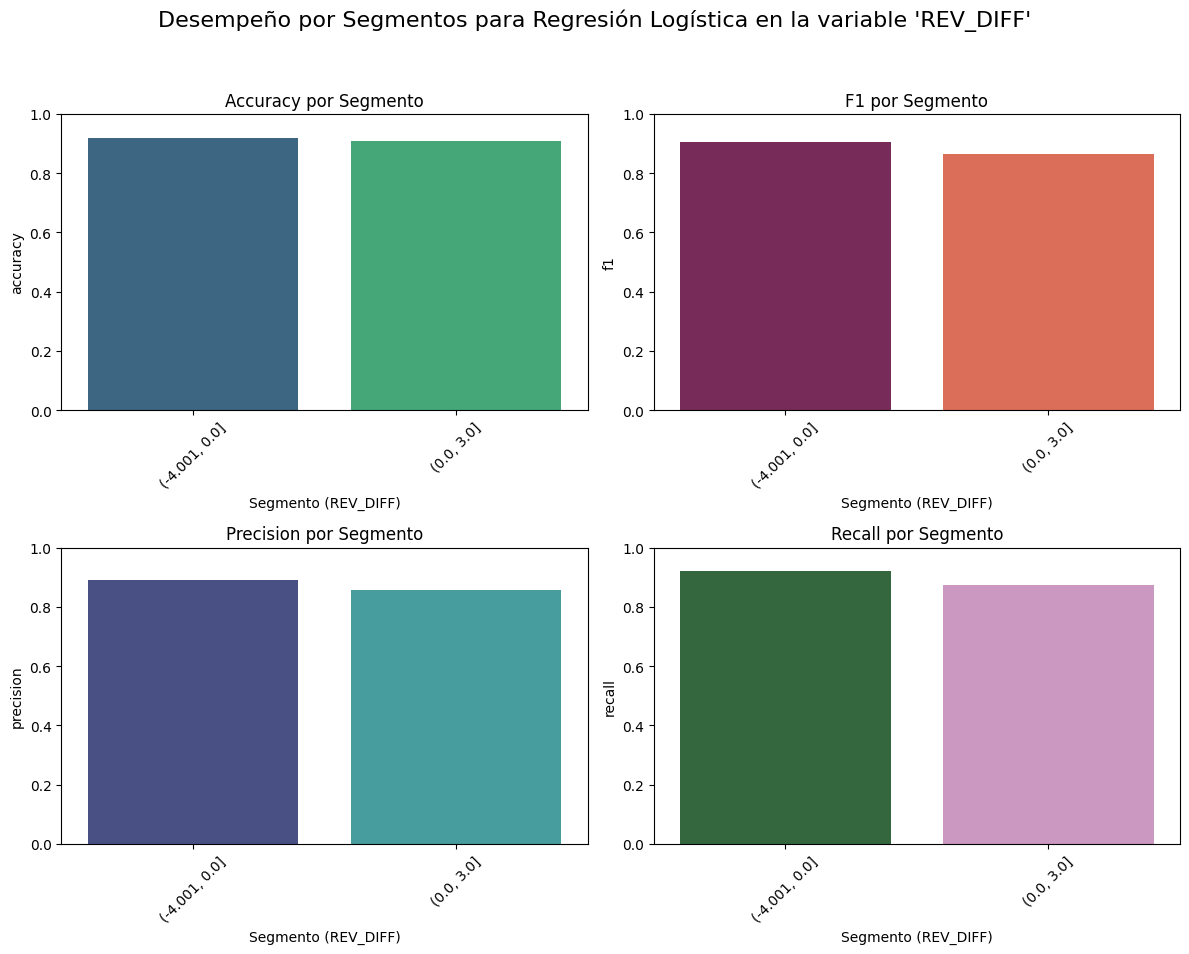


Mostrando la importancia de las variables:


C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importances.head(10), palette="rocket")


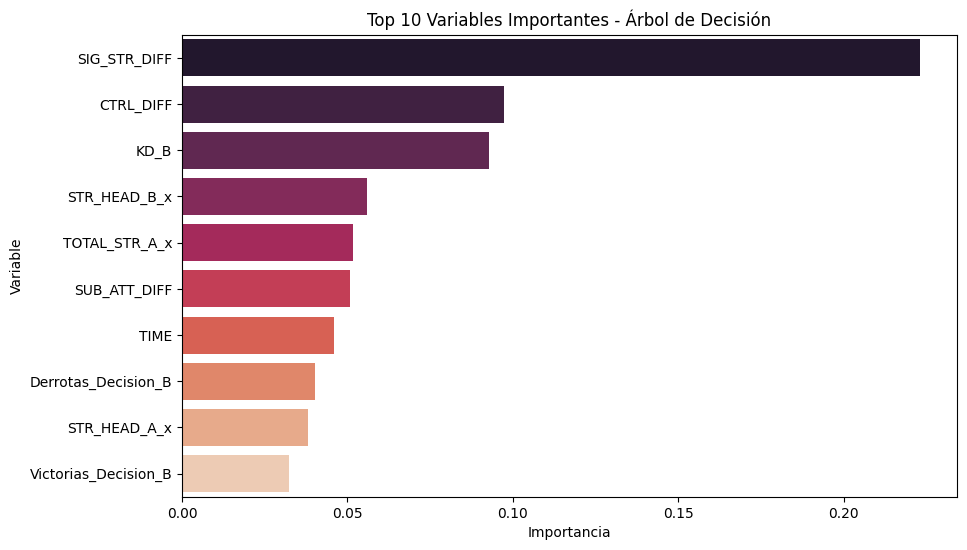

C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importances.head(10), palette="rocket")


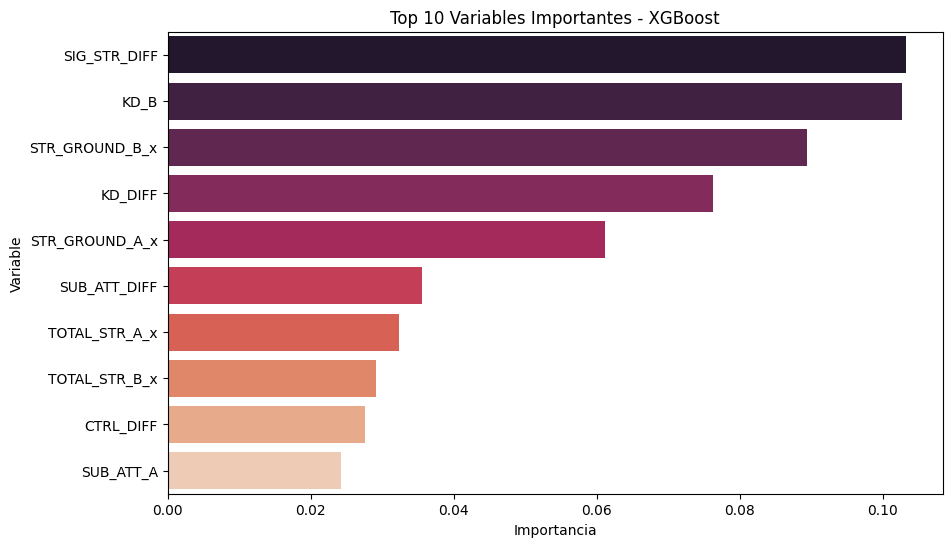

C:\Users\araca\AppData\Local\Temp\ipykernel_19684\437630776.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importances.head(10), palette="rocket")


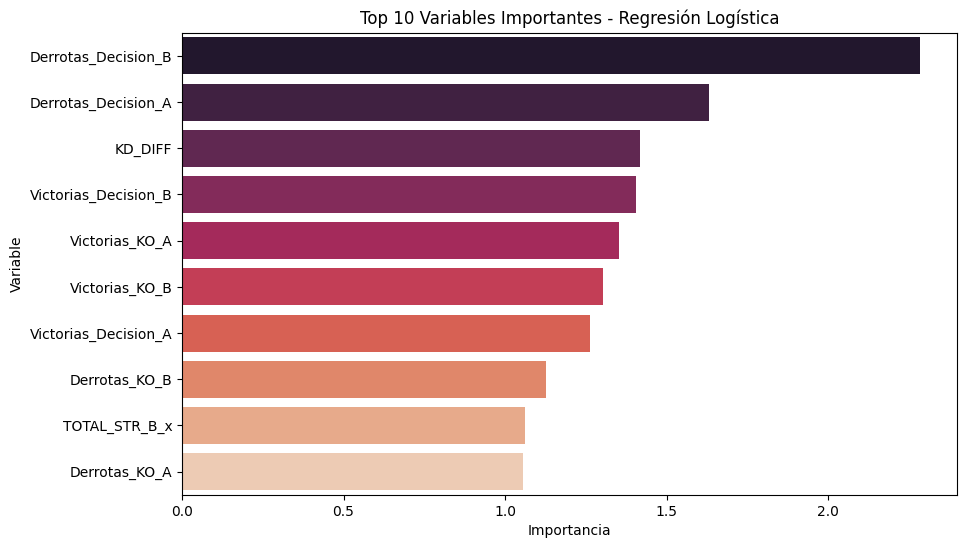

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, log_loss,
                             classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve)


def evaluar_metricas_complementarias(modelo, X, y, nombre):
    """
    Evalúa y muestra métricas adicionales:
    - Accuracy, Precision, Recall, F1, Log Loss
    - Reporte de clasificación y matriz de confusión
    - Curva Precision-Recall
    """
    y_pred = modelo.predict(X)
    y_prob = modelo.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    ll = log_loss(y, y_prob)
    
    print(f"--- {nombre} ---")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Log Loss:", ll)
    print("\nReporte de clasificación:")
    print(classification_report(y, y_pred))
    
    # Matriz de confusión
    plt.figure(figsize=(6,4))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()
    
    # Curva Precision-Recall
    prec_vals, rec_vals, _ = precision_recall_curve(y, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(rec_vals, prec_vals, marker='.')
    plt.title(f"Curva Precision-Recall - {nombre}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "log_loss": ll}


def evaluacion_por_segmentos(modelo, X, y, variable, bins=4, nombre="Modelo"):
    """
    Divide los datos en segmentos usando los cuantiles de la variable 'variable'
    y evalúa el desempeño del modelo en cada segmento.
    
    Se calculan las métricas: Accuracy, F1, Precision y Recall para cada segmento.
    
    Parámetros:
      - modelo: el modelo ya entrenado.
      - X: DataFrame con las características.
      - y: Serie o array con las etiquetas reales.
      - variable: columna de X utilizada para segmentar.
      - bins: número de segmentos.
      - nombre: nombre del modelo (para etiquetado en gráficos).
      
    Retorna un diccionario con las métricas de cada segmento.
    """
    X_seg = X.copy()
    
    # Crear segmentos usando los cuantiles de la variable seleccionada
    try:
        X_seg["segmento"] = pd.qcut(X_seg[variable], bins, duplicates="drop")
    except Exception as e:
        print(f"Error al segmentar con qcut: {e}. Se usará pd.cut en su lugar.")
        X_seg["segmento"] = pd.cut(X_seg[variable], bins)
        
    X_seg["real"] = y
    
    metrics_dict = {}
    
    # Iterar sobre cada segmento
    for segmento, data in X_seg.groupby("segmento"):
        X_temp = data.drop(columns=["segmento", "real"])
        y_temp = data["real"]
        y_pred = modelo.predict(X_temp)
        
        acc = accuracy_score(y_temp, y_pred)
        f1  = f1_score(y_temp, y_pred)
        prec = precision_score(y_temp, y_pred)
        rec  = recall_score(y_temp, y_pred)
        
        metrics_dict[str(segmento)] = {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}
        print(f"Segmento {segmento}: Accuracy={acc:.2f}, F1={f1:.2f}, Precision={prec:.2f}, Recall={rec:.2f}")
    
    # Convertir a DataFrame para graficar
    metrics_df = pd.DataFrame(metrics_dict).T.reset_index().rename(columns={"index": f"Segmento ({variable})"})
    
    # Graficar las métricas
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    
    sns.barplot(x=f"Segmento ({variable})", y="accuracy", data=metrics_df, ax=ax[0,0], palette="viridis")
    ax[0,0].set_title("Accuracy por Segmento")
    
    sns.barplot(x=f"Segmento ({variable})", y="f1", data=metrics_df, ax=ax[0,1], palette="rocket")
    ax[0,1].set_title("F1 por Segmento")
    
    sns.barplot(x=f"Segmento ({variable})", y="precision", data=metrics_df, ax=ax[1,0], palette="mako")
    ax[1,0].set_title("Precision por Segmento")
    
    sns.barplot(x=f"Segmento ({variable})", y="recall", data=metrics_df, ax=ax[1,1], palette="cubehelix")
    ax[1,1].set_title("Recall por Segmento")
    
    for axes in ax.flat:
        axes.set_ylim(0,1)
        for label in axes.get_xticklabels():
            label.set_rotation(45)
    
    plt.suptitle(f"Desempeño por Segmentos para {nombre} en la variable '{variable}'", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return metrics_dict

def plot_feature_importance(modelo, X_train, nombre):
    """
    Visualiza las 10 variables más importantes.
    Para modelos basados en árboles se usa 'feature_importances_'
    y para regresión logística se usan los coeficientes (valor absoluto).
    Se utiliza 'feature_names_in_' si está disponible en el modelo.
    """
    # Para modelos basados en árboles
    if hasattr(modelo, 'feature_importances_'):
        features = modelo.feature_names_in_ if hasattr(modelo, "feature_names_in_") else X_train.columns
        importances = pd.DataFrame({
            "feature": features,
            "importance": modelo.feature_importances_
        }).sort_values("importance", ascending=False)
        
    # Para regresión logística (o modelos con coeficientes)
    elif hasattr(modelo, 'coef_'):
        if hasattr(modelo, "feature_names_in_"):
            features = modelo.feature_names_in_
        else:
            features = X_train.columns
        coef = np.abs(modelo.coef_[0])
        # Si la cantidad de features no coincide, tomar solo la intersección
        if len(features) != len(coef):
            common_features = list(set(features).intersection(set(X_train.columns)))
            features = common_features[:len(coef)]
        importances = pd.DataFrame({
            "feature": features,
            "importance": coef
        }).sort_values("importance", ascending=False)
    else:
        print(f"No se pudo extraer la importancia de variables en {nombre}")
        return
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=importances.head(10), palette="rocket")
    plt.title(f"Top 10 Variables Importantes - {nombre}")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()
    
metricas_totales = {}
for nombre, modelo in modelos.items():
    print("\nEvaluando métricas complementarias para:", nombre)
    if nombre == "Regresión Logística":
        metrics = evaluar_metricas_complementarias(modelo, x_test2, y_test2, nombre)
    else:
        metrics = evaluar_metricas_complementarias(modelo, X_test, y_test, nombre)
    metricas_totales[nombre] = metrics


variable_relevante = "REV_DIFF"
for nombre, modelo in modelos.items():
    print(f"\nEvaluación por segmentos para {nombre} usando la variable '{variable_relevante}'")
    if nombre == "Regresión Logística":
        if variable_relevante in x_test2.columns:
            evaluacion_por_segmentos(modelo, x_test2, y_test2, variable_relevante, bins=4, nombre=nombre)
        else:
            print(f"La variable {variable_relevante} no está presente en x_test2")
    else:
        if variable_relevante in X_test.columns:
            evaluacion_por_segmentos(modelo, X_test, y_test, variable_relevante, bins=4, nombre=nombre)
        else:
            print(f"La variable {variable_relevante} no está presente en X_test")
            
print("\nMostrando la importancia de las variables:")
for nombre, modelo in modelos.items():
    if nombre == "Regresión Logística":
        plot_feature_importance(modelo, X_train, nombre)
    else:
        # Si 'ROUND' es exclusivo de la regresión logística, lo descartamos
        X_temp = X_train.drop(columns=["ROUND"], errors='ignore')
        plot_feature_importance(modelo, X_temp, nombre)